In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
from csvb.ingest import apply_rule, sel_factory, ApplyOp, SelectOp, AOP, SOP, Rule, to_transactions, strip_currency
import plotly.express as px
import plotly.graph_objects as go
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
def accounts(trans):
    return set(trans["From"]).union(set(trans["To"]))

def read_and_apply(df, rulepth, debug=False):
    with open(rulepth) as f:
        for rule in tml.load(f)["rules"]:
            if debug:
                print(rule)
            apply_rule(Rule(**rule), df)
    return df
    

In [3]:
home = pathlib.Path.home()
cfgpth = home / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
cfg

{'title': 'csvb config',
 'paths': {'path': 'als/csvbdata/',
  'bank': 'als/csvbdata/bank',
  'products': 'als/csvbdata/products/',
  'rules': 'als/csvbdata/rules/'}}

In [4]:
try:
    del apl
except NameError:
    pass
dfs = []
for fn in (home / pathlib.Path(cfg["paths"]["bank"])).glob("Apple Card Transactions*.csv"):
    dfs.append(pd.read_csv(fn, header=0, parse_dates=["Transaction Date", "Clearing Date"]))
apl = pd.concat(dfs)
apl = apl.rename(columns={"Amount (USD)": "Amount"})
apl["Amount"] = -1 * apl["Amount"]
apl["From"] = ""

apl = read_and_apply(apl, home / cfg["paths"]["rules"] / "aplrules.toml")
apl = apl.sort_values(["Transaction Date"])
#apl[apl["From"] == ""]
apl

Transaction Date Clearing Date  \
15       2021-12-31    2022-01-03   
16       2021-12-31    2022-01-02   
14       2022-01-01    2022-01-03   
13       2022-01-01    2022-01-03   
12       2022-01-01    2022-01-03   
..              ...           ...   
1        2024-02-29    2024-02-29   
48       2024-02-29    2024-02-29   
49       2024-02-29    2024-02-29   
51       2024-02-29    2024-02-29   
50       2024-02-29    2024-02-29   

                                          Description  \
15  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
16  FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...   
14  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
13  CKO*PATREON* MEMBERSHI600 TOWNSEND 833-9728766...   
12  APPLE.COM/BILL ONE APPLE PARK 1111111111 95014...   
..                                                ...   
1   ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...   
48                    MONTHLY INSTALLMENTS (22 OF 24)   
49                     MONTHLY INSTALLMENTS (1 OF 12)   
51                    MONTHLY INSTALLMENTS (22 OF 24)   
50                     MONTHLY INSTALLMENTS (1 OF 12)   

                                             Merchant       Category  \
15                                     Apple Services          Other   
16                                           Fandango  Entertainment   
14                                     Apple Services          Other   
13                             Cko*Patreon* Membershi          Other   
12                                     Apple Services          Other   
..                                                ...            ...   
1   Ach Deposit Internet Transfer From Account End...        Payment   
48                    Monthly Installments (22 Of 24)    Installment   
49                     Monthly Installments (1 Of 12)    Installment   
51                    Monthly Installments (22 Of 24)    Installment   
50                     Monthly Installments (1 Of 12)    Installment   

           Type   Amount Purchased By                            From  
15     Purchase   -14.99  Keith Davis          Expenses:Subscriptions  
16     Purchase   -11.04  Keith Davis          Expenses:Entertainment  
14     Purchase    -5.99  Keith Davis          Expenses:Subscriptions  
13     Purchase    -7.00  Keith Davis          Expenses:Entertainment  
12     Purchase   -30.14  Keith Davis          Expenses:Subscriptions  
..          ...      ...          ...                             ...  
1       Payment  2161.31  Keith Davis                        Transfer  
48  Installment    -8.29  Keith Davis  Liabilities:Apple:Installments  
49  Installment  -114.08  Keith Davis  Liabilities:Apple:Installments  
51  Installment   -54.12  Keith Davis  Liabilities:Apple:Installments  
50  Installment   -23.25  Keith Davis  Liabilities:Apple:Installments  

[919 rows x 9 columns]

In [5]:
try:
    del fst
except NameError:
    pass

fst = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_1st.csv",
                    header=3, parse_dates=["Date"])

fst_old = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Sep22-2023_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst_older = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan22-Sep22_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst = pd.concat([fst, fst_old, fst_older])

fst["Amount"] = np.nansum([fst["Amount Credit"],fst["Amount Debit"]], axis=0)
fst["From"] = ""

fst = read_and_apply(fst, home / cfg["paths"]["rules"] / "fstrules.toml")
fst[fst["From"] == ""]

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Check Number, Fees  , Amount, From]
Index: []

In [6]:
try:
    del ally
except NameError:
    pass

ally = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_Ally.csv",
                    header=0, parse_dates=["Date"])

ally["From"] = ""
ally = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))

ally = read_and_apply(ally, home / cfg["paths"]["rules"] / "allyrules.toml")
#ally

In [7]:
try:
    del ndfcu
except NameError:
    pass

ndfcu = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan2022-March-2024_NDFCU_CC.csv",
                    header=0, names=["Date", "Note", "Description", "Amount", "Balance"],
                    parse_dates=["Date"])

ndfcu["From"] = ""
ndfcu["Amount"] = ndfcu["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
ndfcu = read_and_apply(ndfcu, home / cfg["paths"]["rules"] / "ndfcurules.toml")
print(len(ndfcu))
ndfcu[ndfcu["From"] == ""]

1009

Date                  Note  \
7    2024-02-21  ACH/DELQ FINE PAYMEN   
12   2024-02-18     A2A DEP INITIATED   
19   2024-02-14        CC SALES DRAFT   
20   2024-02-13        CC SALES DRAFT   
21   2024-02-13        CC SALES DRAFT   
...         ...                   ...   
995  2022-01-14        CC SALES DRAFT   
996  2022-01-14        CC SALES DRAFT   
999  2022-01-13  A2A TRANSFER DEPOSIT   
1004 2022-01-02        CC SALES DRAFT   
1006 2022-01-01        CC SALES DRAFT   

                                            Description  Amount    Balance  \
7                                                   NaN  -25.00  $1,639.17   
12    REQSTD $1.000.00    FROM FIRST SOURCE BANK 878...    0.00  $2,499.17   
19    BSU STUDENT CTR          . MUNCIE       . IN 0...   -7.93  $2,267.78   
20    THAI SMILE RESTA         . MUNCIE       . IN 0...  -44.88  $2,259.85   
21    BSU LA PITTENGER         . MUNCIE       . IN 0... -110.88  $2,214.97   
...                                                 ...     ...        ...   
995   BATTERIES PLUS 003       . MISHAWAKAI   . IN 0000   -9.62    $107.58   
996   CITY OF SOUTH BEND       . 574-223-0311 . IN 0000  -88.80     $97.96   
999          For $1.929.62 FROM FIRST SOURC REQSTD 1/13    0.00  $1,929.62   
1004  CROSSFIT SOUTH BEND      . MISHAWAKA    . IN 0000  -38.00  $1,831.50   
1006  CVS/PHARMACY #08642      . SOUTH BEND   . IN 0000  -24.70  $1,746.12   

     From  
7          
12         
19         
20         
21         
...   ...  
995        
996        
999        
1004       
1006       

[491 rows x 6 columns]

In [8]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu}


trans = to_transactions(bank_tables)
trans.sort_values("Date")

Date                                        Description   Amount  \
0    2021-12-31  FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...   -11.04   
1    2021-12-31  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   -14.99   
2    2022-01-01  APPLE.COM/BILL ONE APPLE PARK 1111111111 95014...   -30.14   
3    2022-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...    -5.99   
4    2022-01-01  CKO*PATREON* MEMBERSHI600 TOWNSEND 833-9728766...    -7.00   
...         ...                                                ...      ...   
1297 2024-02-29  ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...  2161.31   
1299 2024-02-29                    MONTHLY INSTALLMENTS (22 OF 24)   -54.12   
1295 2024-02-29                     MONTHLY INSTALLMENTS (1 OF 12)  -114.08   
1296 2024-02-29                                 APPLE CASH PAYMENT    87.47   
1300 2024-02-29                     MONTHLY INSTALLMENTS (1 OF 12)   -23.25   

                                From                             To  
0             Expenses:Entertainment  Liabilities:Apple:Credit Card  
1             Expenses:Subscriptions  Liabilities:Apple:Credit Card  
2             Expenses:Subscriptions  Liabilities:Apple:Credit Card  
3             Expenses:Subscriptions  Liabilities:Apple:Credit Card  
4             Expenses:Entertainment  Liabilities:Apple:Credit Card  
...                              ...                            ...  
1297                        Transfer  Liabilities:Apple:Credit Card  
1299  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  
1295  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  
1296               Income:Apple Cash  Liabilities:Apple:Credit Card  
1300  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  

[1301 rows x 5 columns]

In [9]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])

#bal_decl["From"] = ""
#bal["Amount"] = bal["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
#bal_decl = bal_decl.sort_values("Date")
#bal_decl
#jan_bal = bal_decl.loc[(bal_decl["Date"] >= pd.Timestamp(2023, 12, 31)) &
#                       (bal_decl["Date"] <= pd.Timestamp(2024, 1, 1))
#trans = pd.concat([trans, bal_decl])
bal_decl

Date                         Account  Statement Balance
0  2021-12-31   Liabilities:Apple:Credit Card           -2522.77
1  2021-12-31      Assets:1st Source:Checking            5067.54
2  2022-12-31   Liabilities:NDFCU:Credit Card             -76.69
3  2023-11-30   Liabilities:NDFCU:Credit Card           -2085.08
4  2023-10-31   Liabilities:NDFCU:Credit Card           -2492.89
5  2023-09-30   Liabilities:NDFCU:Credit Card           -1581.47
6  2023-08-31   Liabilities:NDFCU:Credit Card             -69.79
7  2023-07-31   Liabilities:NDFCU:Credit Card           -3172.26
8  2023-06-30   Liabilities:NDFCU:Credit Card           -1409.14
9  2023-05-31   Liabilities:NDFCU:Credit Card            -351.48
10 2023-04-30   Liabilities:NDFCU:Credit Card           -3924.01
11 2023-03-31   Liabilities:NDFCU:Credit Card           -2519.52
12 2023-02-28   Liabilities:NDFCU:Credit Card            -885.51
13 2023-01-31   Liabilities:NDFCU:Credit Card           -1376.20
14 2023-11-30   Liabilities:Apple:Credit Card            -201.50
15 2023-11-30  Liabilities:Apple:Installments            -374.62
16 2023-10-31   Liabilities:Apple:Credit Card            -151.48
17 2023-10-31  Liabilities:Apple:Installments            -437.03
18 2024-01-30      Assets:1st Source:Checking            1297.66
19 2024-02-18             Assets:Ally:Savings           10330.00
20 2023-10-18             Assets:Ally:Savings            8793.47
21 2023-11-18             Assets:Ally:Savings            9425.23
22 2024-01-31             Assets:Fidelity:HSA            3956.09
23 2024-01-31   Liabilities:NDFCU:Credit Card           -1565.79
24 2023-11-30   Liabilities:NDFCU:Credit Card           -2085.08
25 2023-12-31   Liabilities:NDFCU:Credit Card             -99.77
26 2023-12-18             Assets:Ally:Savings           10058.08
27 2023-12-31      Assets:1st Source:Checking            2320.59
28 2024-01-18             Assets:Ally:Savings            9694.18
29 2024-01-18             Assets:Ally:Savings            9694.18
30 2023-12-31             Assets:Fidelity:HSA            3939.33
31 2023-12-31   Liabilities:Apple:Credit Card            -284.77
32 2023-12-31  Liabilities:Apple:Installments            -312.21
33 2021-12-31  Liabilities:Apple:Installments            -738.94

In [10]:
def create_ledgers(trans):
    """ Create a ledger for each account of all from / to transactions and create balance / time column.
    'Transaction Pair' is a terrible name, but it reminds that this is 1 half of a known transation for use
    as a ledger of an account and running balance calculation.
    All values appended from the "From" side of a transaction are reversed here, because a positive value
    "From" this account subtracts from it's balance.
    
    """
    # TODO: Add an option of a start of / end of period dates. Automatically calculate balance at
    # beginning of period.
    # TODO: Add processing of balance assertions to allow checks and reconciliation.
    
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    ledgers = {}
    for acct in accounts(trans):
        # From accounts, note the negative applied to Amount.
        try:
            df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
            df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
            ledgers[acct] = df
        # If account is not in From group, skip.
        except KeyError:
            pass

        # To accounts.

        try:
            df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
            df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
            try:
                ledgers[acct] = pd.concat([ledgers[acct], df])
            # If account was not also in From accounts list, don't concat.
            except KeyError:
                ledgers[acct] = df
        # If account is not in list To accounts, skip.
        except KeyError:
            pass
            
        # Sort and apply cumulative sum.
        ledgers[acct] = ledgers[acct].sort_values("Date")
        ledgers[acct]["Balance"] = ledgers[acct]["Incoming Amount"].cumsum()

    return ledgers

def trans_to_ledger(trans, acct, bal_decl = None, clean=False, leq=True):
    """ Craete a single ledger. This is a step to using ledgers as a view on the transactions rather than
    a precalcualted object.
    
    """   
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    #ledgers = {}
    #for acct in accounts(trans):
    # From accounts, note the negative applied to Amount.
    try:
        df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
        df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
        ledger = df
        # If account is not in From group, skip.
    except KeyError:
        pass

    # To accounts.

    try:
        df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
        df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
        try:
            ledger = pd.concat([ledger, df])
        # If account was not also in From accounts list, don't concat.
        except (NameError, UnboundLocalError):
            ledger = df
    # If account is not in list To accounts, skip.
    except KeyError:
        pass
    if clean:
        ledger = clean_ledger(ledger)        
    # Sort and apply cumulative sum.
    
    if bal_decl is not None:
        ledger = append_init_row(ledger, acct, bal_decl, leq=leq)
    ledger = ledger.sort_values("Date")
    ledger["Balance"] = ledger["Incoming Amount"].cumsum()

    return ledger

def clean_ledger(ledger):
    """Remove transactions occurring before the last transaction with all accounts assigned.
    Intended to catch incomplete data and return a useful ledger set on a per account basis.
    """
    #clean = {}
    #for acct in ledgers:
    try:
        clean = ledger.loc[[ledger["From"] == ""]:,:]
    except KeyError:
        clean = ledger
        
    return clean

def init_balance(bal_decl, acct, first_date, leq=False):
    #first_date = min(ledger["Date"])
    if leq:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] <= first_date)]
    else:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] < first_date)]
    
    # Catch indexerror if no balance found.
    try:
        return acct_balances.sort_values("Date").iloc[-1]
    except IndexError:
        return None

def append_init_row(ledger, acct, bal_decl, leq=False):
    #print(acct)
    #print(ledger)
    # Find proper initial balance.
    init = init_balance(bal_decl, acct, min(ledger["Date"]), leq=leq)

    # Skip if no appropriate balance was found.
    if init is not None:
        
        # Create df of initial balance row.
        decl_to_ledg_col = {"Statement Balance": "Incoming Amount", "Account": "Transaction Pair"}
        init_df = pd.DataFrame(init).T.rename(columns=decl_to_ledg_col)
        init_df["Description"] = "Initial Balance"

        # Add to first row, make sure we are sorted before recalculating balance column.
        ledger = pd.concat([init_df, ledger]).sort_values("Date")
        ledger["Balance"] = ledger["Incoming Amount"].cumsum()
    return ledger  
        

#ledgers = create_ledgers(trans)
ledgers = {}
for acct in accounts(trans):
    ledgers[acct] = trans_to_ledger(trans, acct, bal_decl=bal_decl, clean=True)

In [11]:
bals = []
firstds = []
lastds = []
initbals = []

for acct in ledgers:
    bals.append(ledgers[acct]["Incoming Amount"].sum())
    firstds.append(ledgers[acct]["Date"].iloc[0])
    lastds.append(ledgers[acct]["Date"].iloc[-1])
    initial = ledgers[acct].loc[ledgers[acct]["Description"] == "Initial Balance"]
    if len(initial) != 0:
        initbals.append(initial["Balance"].iloc[0])
    else:
        initbals.append(0)
    #initbals.append(ledgers[acct]["Balance"].iloc[0])
    
acct_bals = pd.DataFrame({"Period Start": firstds,
                          "Initial Balance": initbals,
                          "Period End": lastds,
                          "Ending Balance": bals},
                         index = ledgers.keys())
acct_bals.index.name = "Account"


In [12]:
acct_bals["Difference"] = acct_bals["Ending Balance"] - acct_bals["Initial Balance"]
acct_bals

Period Start  Initial Balance Period End  \
Account                                                                    
Expenses:Home:Repairs             2022-08-02             0.00 2022-08-02   
Expenses:Auto:Insurance           2022-06-10             0.00 2023-12-27   
Expenses:Home:Maintenance         2022-04-05             0.00 2023-10-24   
Expenses:Projects                 2022-04-19             0.00 2022-12-06   
Expenses:Utilities                2022-01-12             0.00 2024-02-18   
Expenses:Auto:Gas                 2023-06-13             0.00 2024-02-16   
Transfer                          2022-01-07             0.00 2024-02-29   
Expenses:Fitness:ID               2022-06-24             0.00 2024-01-25   
Expenses:Gifts                    2024-01-03             0.00 2024-01-03   
Expenses:Auto:Tolls               2022-12-16             0.00 2024-01-22   
Assets:Ally:Savings               2023-12-18         10058.08 2024-02-09   
Expenses:Travel                   2022-12-18             0.00 2024-02-21   
Expenses:Auto:Registration        2023-04-12             0.00 2023-04-12   
Expenses:Charity                  2022-04-25             0.00 2023-11-01   
Transfer:Apple:Installments       2022-05-20             0.00 2022-05-20   
Transfer:Auto:Loan                2022-01-11             0.00 2022-07-11   
Expenses:Fitness:Equipment        2022-05-16             0.00 2022-05-16   
Expenses:Study                    2022-02-17             0.00 2024-02-12   
Expenses:Electronics              2022-05-05             0.00 2024-02-09   
Expenses:Subscriptions            2021-12-31             0.00 2024-02-28   
Expenses:Home Furnishings         2022-05-30             0.00 2023-10-20   
Expenses:Pet                      2022-01-19             0.00 2024-02-22   
Expenses:Pet:Care                 2022-02-11             0.00 2023-12-19   
Income:Notre Dame:Regular         2022-01-31             0.00 2024-01-31   
Expenses:Home:Furnishings         2022-09-06             0.00 2023-10-21   
Assets:1st Source:Checking        2021-12-31          5067.54 2024-01-31   
Expenses:Cash                     2022-01-10             0.00 2023-07-18   
Expenses:Entertainment:Self       2022-03-13             0.00 2024-02-02   
Expenses:Medical:Recovery         2023-01-29             0.00 2023-01-29   
Expenses:Entertainment            2021-12-31             0.00 2024-02-19   
Liabilities:Apple:Installments    2021-12-31          -738.94 2024-02-29   
Expenses:Home:Cleaning            2022-12-15             0.00 2024-02-18   
Expenses:Groceries                2022-01-04             0.00 2024-02-26   
Expenses:Medical:Therapy          2024-01-14             0.00 2024-01-14   
Transfer:Ally:Savings             2022-08-03             0.00 2024-01-09   
Expenses:Medical:Body             2022-01-14             0.00 2024-02-27   
Liabilities:Apple:Credit Card     2021-12-31         -2522.77 2024-02-29   
Income:Interest                   2022-01-24             0.00 2024-01-30   
Expenses:Auto:Maintenance         2022-08-23             0.00 2022-08-23   
Liabilities:NDFCU:Credit Card     2023-12-31           -99.77 2024-01-30   
Expenses:Auto:Fuel                2023-11-27             0.00 2024-01-12   
Expenses:Reimbursible             2022-10-17             0.00 2024-02-21   
Expenses:Restaurants              2022-02-09             0.00 2024-02-24   
Transfer:NDFCU:Credit Card        2022-01-14             0.00 2023-12-27   
Income:Apple Cash                 2022-01-28             0.00 2024-02-29   
Expenses:Professional             2022-10-06             0.00 2022-12-05   
Income:Taxes                      2022-04-10             0.00 2023-03-14   
Expenses:Gear                     2022-01-05             0.00 2024-01-24   
Expenses:Entertainment:Personal   2022-02-21             0.00 2024-02-21   
Expenses:Entertainment:Reading    2022-05-03             0.00 2024-02-27   
Expenses:Home                     2022-06-06             0.00 2024-01-30   
Expe

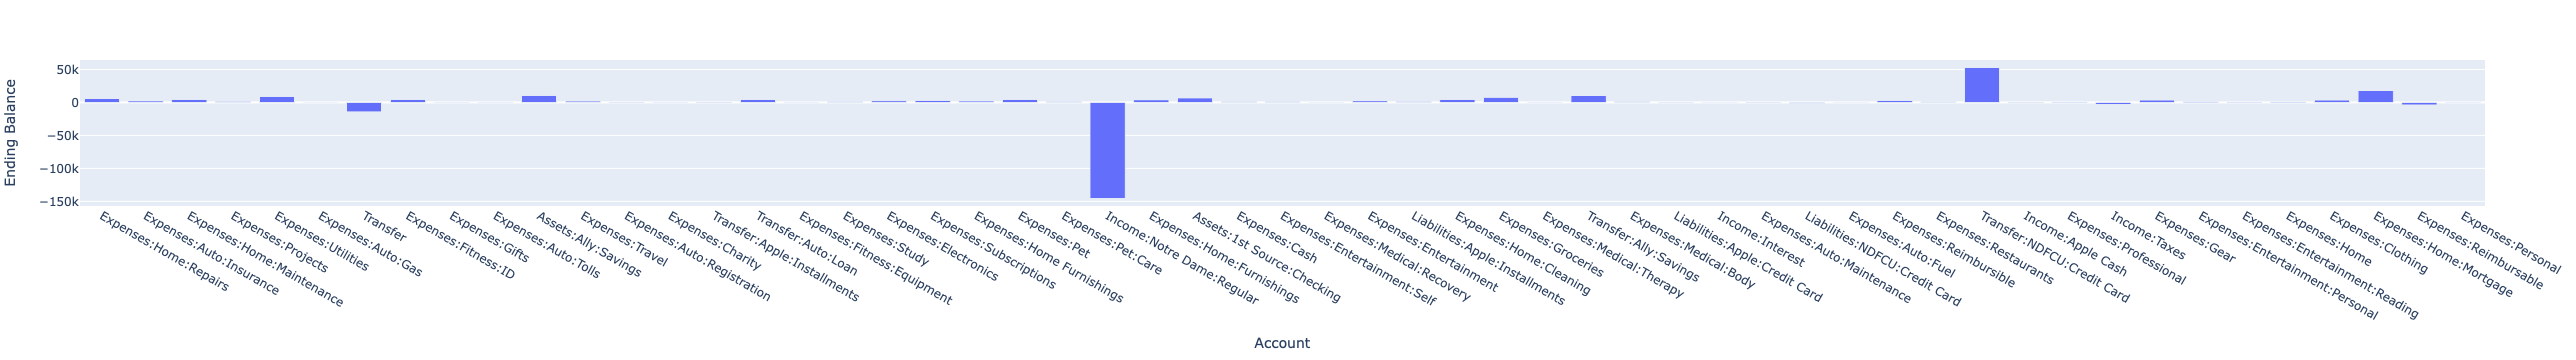

In [13]:
fig = px.bar(acct_bals, x=acct_bals.index, y="Ending Balance")
fig.show()

In [14]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])

In [15]:
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))
flow_df

Amount
From                          To                                     
Assets:1st Source:Checking    Expenses:Auto:Insurance         2042.05
                              Expenses:Auto:Registration       260.35
                              Expenses:Cash                   1313.25
                              Expenses:Fitness:Equipment       100.00
                              Expenses:Fitness:ID             4725.00
...                                                               ...
Liabilities:NDFCU:Credit Card Expenses:Utilities               107.05
Transfer                      Assets:1st Source:Checking      9500.00
                              Assets:Ally:Savings             1200.00
                              Liabilities:Apple:Credit Card  52571.68
Transfer:Apple:Installments   Assets:1st Source:Checking       481.50

[73 rows x 1 columns]

In [16]:
accts = list(accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )

labels

['Expenses:Utilities',
 'Transfer',
 'Expenses:Gifts',
 'Expenses:Fitness:ID',
 'Expenses:Auto:Tolls',
 'Expenses:Charity',
 'Transfer:Auto:Loan',
 'Expenses:Electronics',
 'Expenses:Subscriptions',
 'Expenses:Pet',
 'Expenses:Home:Furnishings',
 'Expenses:Pet:Care',
 'Expenses:Cash',
 'Expenses:Medical:Recovery',
 'Expenses:Home:Cleaning',
 'Expenses:Groceries',
 'Expenses:Medical:Body',
 'Expenses:Auto:Maintenance',
 'Liabilities:NDFCU:Credit Card',
 'Expenses:Professional',
 'Expenses:Entertainment:Personal',
 'Expenses:Entertainment:Reading',
 'Expenses:Home',
 'Expenses:Home:Mortgage',
 'Expenses:Reimbursable',
 'Expenses:Personal',
 'Expenses:Home:Repairs',
 'Expenses:Auto:Insurance',
 'Expenses:Home:Maintenance',
 'Expenses:Projects',
 'Expenses:Auto:Gas',
 'Assets:Ally:Savings',
 'Expenses:Travel',
 'Expenses:Auto:Registration',
 'Transfer:Apple:Installments',
 'Expenses:Fitness:Equipment',
 'Expenses:Study',
 'Expenses:Home Furnishings',
 'Assets:1st Source:Checking',
 'Income

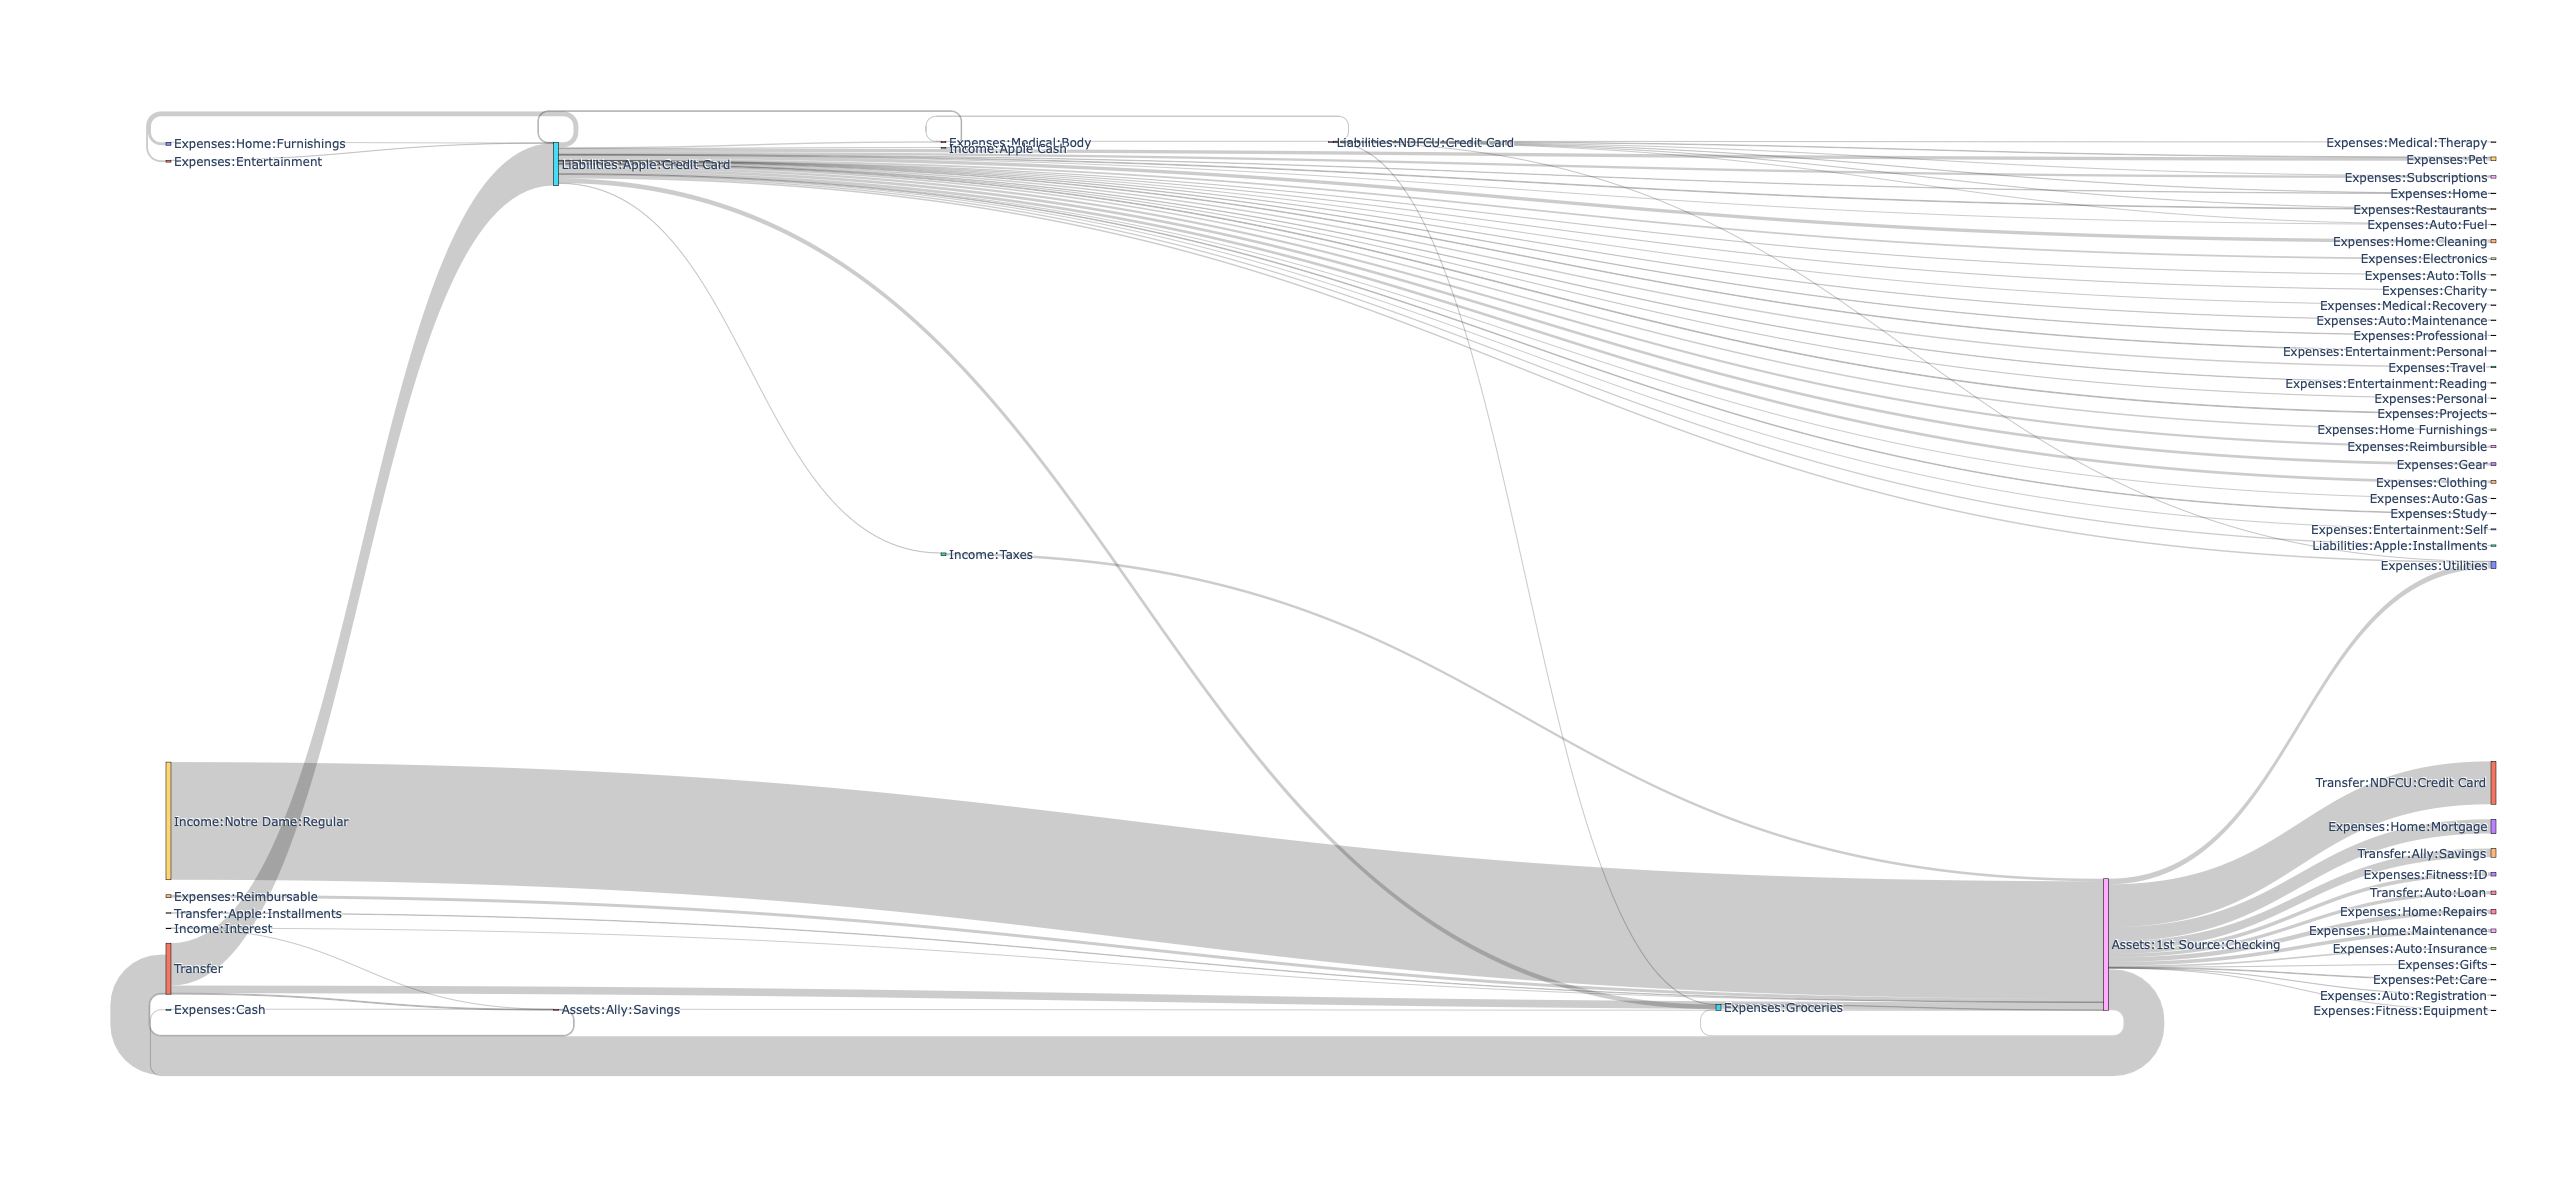

In [17]:
f.update_layout(height=1200)
f.show()

In [39]:
print(list(zip(sources, targets)))
print(list(zip([accts[s] for s in sources], [accts[t] for t in targets])))

[
    (0, 32),
    (32, 0),
    (32, 9),
    (32, 15),
    (32, 23),
    (32, 2),
    (32, 28),
    (32, 24),
    (32, 21),
    (32, 34),
    (32, 11),
    (32, 22),
    (26, 34),
    (23, 32),
    (27, 19),
    (13, 21),
    (3, 32),
    (3, 26),
    (1, 32),
    (21, 12),
    (21, 17),
    (21, 30),
    (21, 16),
    (21, 20),
    (21, 33),
    (21, 8),
    (21, 23),
    (21, 4),
    (21, 27),
    (21, 10),
    (21, 25),
    (21, 7),
    (21, 24),
    (21, 6),
    (19, 29),
    (19, 23),
    (19, 18),
    (19, 27),
    (19, 14),
    (19, 31),
    (19, 10),
    (19, 5),
    (19, 24),
    (34, 32),
    (34, 26)
]

[
    ('', 'Assets:1st Source:Checking'),
    ('Assets:1st Source:Checking', ''),
    ('Assets:1st Source:Checking', 'Expenses:Auto:Insurance'),
    ('Assets:1st Source:Checking', 'Expenses:Gifts'),
    ('Assets:1st Source:Checking', 'Expenses:Groceries'),
    ('Assets:1st Source:Checking', 'Expenses:Home:Mortgage'),
    ('Assets:1st Source:Checking', 'Expenses:Pet:Care'),
    ('Assets:1st Source:Checking', 'Expenses:Utilities'),
    ('Assets:1st Source:Checking', 'Liabilities:Apple:Credit Card'),
    ('Assets:1st Source:Checking', 'Transfer:Ally:Savings'),
    ('Assets:1st Source:Checking', 'Transfer:Apple:Credit Card'),
    ('Assets:1st Source:Checking', 'Transfer:NDFCU:Credit Card'),
    ('Assets:Ally:Savings', 'Transfer:Ally:Savings'),
    ('Expenses:Groceries', 'Assets:1st Source:Checking'),
    ('Expenses:Medical:Body', 'Liabilities:NDFCU:Credit Card'),
    ('Income:Apple Cash', 'Liabilities:Apple:Credit Card'),
    ('Income:Interest', 'Assets:1st Source:Checking'),
    ('Income:Interest', 'Assets:Ally:Savings'),
    ('Income:Notre Dame:Regular', 'Assets:1st Source:Checking'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Auto:Gas'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Auto:Tolls'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Clothing'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment:Reading'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment:Self'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Gear'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Groceries'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Home:Cleaning'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Medical:Body'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Restaurants'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Study'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Subscription'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Utilities'),
    ('Liabilities:Apple:Credit Card', 'Liabilities:Apple:Installments'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Auto:Fuel'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Groceries'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Home'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Medical:Body'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Medical:Therapy'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Pet'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Restaurants'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Subscriptions'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Utilities'),
    ('Transfer:Ally:Savings', 'Assets:1st Source:Checking'),
    ('Transfer:Ally:Savings', 'Assets:Ally:Savings')
]

In [40]:
accts

['',
 'Income:Notre Dame:Regular',
 'Expenses:Home:Mortgage',
 'Income:Interest',
 'Expenses:Home:Cleaning',
 'Expenses:Subscriptions',
 'Liabilities:Apple:Installments',
 'Expenses:Subscription',
 'Expenses:Gear',
 'Expenses:Auto:Insurance',
 'Expenses:Restaurants',
 'Transfer:Apple:Credit Card',
 'Expenses:Auto:Gas',
 'Income:Apple Cash',
 'Expenses:Medical:Therapy',
 'Expenses:Gifts',
 'Expenses:Entertainment',
 'Expenses:Auto:Tolls',
 'Expenses:Home',
 'Liabilities:NDFCU:Credit Card',
 'Expenses:Entertainment:Reading',
 'Liabilities:Apple:Credit Card',
 'Transfer:NDFCU:Credit Card',
 'Expenses:Groceries',
 'Expenses:Utilities',
 'Expenses:Study',
 'Assets:Ally:Savings',
 'Expenses:Medical:Body',
 'Expenses:Pet:Care',
 'Expenses:Auto:Fuel',
 'Expenses:Clothing',
 'Expenses:Pet',
 'Assets:1st Source:Checking',
 'Expenses:Entertainment:Self',
 'Transfer:Ally:Savings']

In [41]:
trans[trans["From"] == "Assets:1st Source:Checking"]

Date                                        Description   Amount  \
299 2024-01-31  ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...  2315.13   

                           From                             To  
299  Assets:1st Source:Checking  Liabilities:Apple:Credit Card

In [42]:
trans[trans["Description"].str.contains("VENMO")]

Date    Description  Amount                From  \
20  2022-10-25  VENMO PAYMENT  -180.0   Expenses:Pet:Care   
53  2022-12-22  VENMO PAYMENT   -60.0   Expenses:Pet:Care   
136 2023-06-13  VENMO PAYMENT   -30.0   Expenses:Pet:Care   
143 2023-06-28  VENMO PAYMENT  -180.0   Expenses:Pet:Care   
173 2023-09-07  VENMO PAYMENT   -16.0  Expenses:Groceries   
204 2023-11-29  VENMO PAYMENT  -165.0   Expenses:Pet:Care   
215 2023-12-19  VENMO PAYMENT  -105.0   Expenses:Pet:Care   
239 2024-01-03  VENMO PAYMENT  -125.0      Expenses:Gifts   

                             To  
20   Assets:1st Source:Checking  
53   Assets:1st Source:Checking  
136  Assets:1st Source:Checking  
143  Assets:1st Source:Checking  
173  Assets:1st Source:Checking  
204  Assets:1st Source:Checking  
215  Assets:1st Source:Checking  
239  Assets:1st Source:Checking